In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from dataloader import WikipediaDataModule
from model import AbstractModel, CoordinateAscentModel
from utils import get_profile_embeddings_by_model_key

import argparse
import collections
import glob
import os
import re

import datasets
import pandas as pd
import torch
import transformers
from tqdm import tqdm


from model_cfg import model_paths_dict

datasets.utils.logging.set_verbosity_error()


num_cpus = len(os.sched_getaffinity(0))


def get_profile_embeddings(model_key: str):
    profile_embeddings = get_profile_embeddings_by_model_key(model_key=model_key)

    print("concatenating train, val, and test profile embeddings")
    all_profile_embeddings = torch.cat(
        (profile_embeddings['test'], profile_embeddings['val'], profile_embeddings['train']), dim=0
    )

    print("all_profile_embeddings:", all_profile_embeddings.shape)
    return all_profile_embeddings

def load_adv_csv(dm: WikipediaDataModule, max_num_samples: int = 100) -> pd.DataFrame:
    # Load adv CSVs
    adv_df = None
    adv_csvs_folder = os.path.normpath(
        os.path.join(
            os.getcwd(), os.pardir, 'adv_csvs_full_7'
        )
    )
    print('adv_csvs_folder', adv_csvs_folder)
    model_csv_filenames = list(glob.glob(
        os.path.join(
            adv_csvs_folder,
            'model*/results*__b_*ts10*__k_*__n_100*.csv'
        )
    ) )
    print("len(model_csv_filenames) =", len(model_csv_filenames))
    for filename in (model_csv_filenames):
        print('filename:', filename)
        df = pd.read_csv(filename)
        try:
            df['model_name'] = re.search(r'adv_csvs_full_7/(model_\d.+)/.+.csv', filename).group(1)
            df['k'] = re.search(r'adv_csvs_full_7/.+/.+__k_(\d+)__.+.csv', filename).group(1)
            df['p'] = float(re.search(r'adv_csvs_full_7/.+/.+__mp(\d\.\d+)__.+.csv', filename).group(1))# this is now max percent words, not actually k.
            df['i'] = df.index
            df['filename'] = filename
        except:
            print('could not parse filename', filename)
            continue

        df = df[(df['result_type'] == 'Successful') | (df['result_type'] == 'Skipped')]

        mini_df = df[['perturbed_text', 'model_name', 'filename', 'i', 'k', 'p']]
        mini_df = mini_df.iloc[:max_num_samples]

        if adv_df is None:
            adv_df = mini_df
        else:
            adv_df = pd.concat((adv_df, mini_df), axis=0)
    
    # Load baseline redacted data
    mini_test_dataset = dm.test_dataset[:max_num_samples]
    doc_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document']
    )
    doc_df['model_name'] = 'document'
    doc_df['i'] = doc_df.index
    doc_df['filename'] = 'document'
    
    ner_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_ner_bert']
    )
    ner_df['model_name'] = 'named_entity'
    ner_df['i'] = ner_df.index
    ner_df['filename'] = 'named_entity'
        
    lex_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_lexical']
    )
    lex_df['model_name'] = 'lexical'
    lex_df['i'] = lex_df.index
    lex_df = lex_df.iloc[:max_num_samples]
    lex_df['filename'] = 'lexical'

    # Combine both adversarial and baseline redacted data
    baseline_df = pd.concat((doc_df, lex_df, ner_df), axis=0)
    baseline_df['k'] = 0
    baseline_df['p'] = 0
    
    full_df = pd.concat((adv_df, baseline_df), axis=0)

    # Put newlines back
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<SPLIT>', '\n'))

    # Standardize mask tokens
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('[MASK]', dm.mask_token))
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<mask>', dm.mask_token))
    
    # Fair truncation
    full_df['original_num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    for i in full_df['i'].unique():
        #         df.loc[df.loc[df['a'] == 1,'b'].index[1], 'b'] = 3
        min_num_words = full_df[full_df['i'] == i]['original_num_words'].min()
        full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'] = (
            full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'].map(
                lambda t: ' '.join(t.split()[:min_num_words])
            )
        )
    
    full_df['num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    
    
    # This makes sure sure all documents with a given index have the same number of words.
    assert full_df.groupby('i')['num_words'].std().max() == 0.0

    return full_df


def get_adv_predictions(model_key: str):
    checkpoint_path = model_paths_dict[model_key]
    assert isinstance(checkpoint_path, str), f"invalid checkpoint_path {checkpoint_path} for {model_key}"
    print(f"running eval on {model_key} loaded from {checkpoint_path}")
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )

    print(f"loading data with {num_cpus} CPUs")
    dm = WikipediaDataModule(
        document_model_name_or_path=model.document_model_name_or_path,
        profile_model_name_or_path=model.profile_model_name_or_path,
        dataset_name='wiki_bio',
        dataset_train_split='train[:256]',
        dataset_val_split='val[:256]',
        dataset_test_split='test[:100%]',
        dataset_version='1.2.0',
        num_workers=num_cpus,
        train_batch_size=256,
        eval_batch_size=256,
        max_seq_length=128,
        sample_spans=False,
    )
    dm.setup("fit")

    adv_csv = load_adv_csv(dm=dm)

    all_profile_embeddings = get_profile_embeddings(model_key=model_key).cuda()

    model.document_model.eval()
    model.document_model.cuda()
    model.document_embed.eval()
    model.document_embed.cuda()

    topk_values = []
    topk_idxs = []
    batch_size = 256
    i = 0
    while i < len(adv_csv):
        ex = adv_csv.iloc[i:i+batch_size]
        test_batch = dm.document_tokenizer.batch_encode_plus(
            ex['perturbed_text'].tolist(),
            max_length=dm.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        test_batch = {
            f'perturbed_text__{k}': v for k,v in test_batch.items()
        }
        with torch.no_grad():
            document_embeddings = model.forward_document(batch=test_batch, document_type='perturbed_text')
            document_to_profile_logits = document_embeddings @ all_profile_embeddings.T
            document_to_profile_probs = document_to_profile_logits.softmax(dim=1)
            topk_10 = document_to_profile_probs.topk(10)
            topk_values.append(topk_10.values)
            topk_idxs.append(topk_10.indices)

        i += batch_size
    
    adv_csv['pred_topk_values'] = torch.cat(topk_values, dim=0).cpu().tolist()
    adv_csv['pred_topk_idxs'] = torch.cat(topk_idxs, dim=0).cpu().tolist()
    return adv_csv



In [2]:
roberta_tapas_predictions = get_adv_predictions(model_key='model_3_2')
roberta_roberta_predictions = get_adv_predictions(model_key='model_3_3')
pmlm_tapas_predictions = get_adv_predictions(model_key='model_3_4')

running eval on model_3_2 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/ojgxa1tf_6/checkpoints/epoch=65-step=150282-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7
len(model_csv_filenames) = 24
filename: /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7/model_3_4/results__b_1__ts10.0__idf0.0__mp0.98__k_6__n_100__type_swap__with_train.csv
filename: /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7/model_3_4/results__b_1__ts10.0__idf0.0__mp0.97__k_0__n_100__type_swap.csv
filename: /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7/model_3_4/results__b_1__ts10.0__idf0.0__mp0.9__k_0__n_100__type_swap.csv
filename: /home/jxm3/research/deidentification/

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaMod

Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7
len(model_csv_filenames) = 24
filename: /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7/model_3_4/results__b_1__ts10.0__idf0.0__mp0.98__k_6__n_100__type_swap__with_train.csv
filename: /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7/model_3_4/results__b_1__ts10.0__idf0.0__mp0.97__k_0__n_100__type_swap.csv
filename: /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_7/model_3_4/results__b_1__ts10.0__idf0.0__mp0.9__k_0__n_100__type_swap.csv
filename: /home/jxm3/research/deidentification/

In [3]:
new_model_name = {
    'model_3_1': 'roberta_tapas__no_masking',
    'model_3_2': 'roberta_tapas',
    'model_3_3': 'roberta_roberta',
    'model_3_4': 'pmlm_tapas',
}
# roberta_predictions = roberta_predictions
roberta_roberta_predictions['model_name'] = roberta_roberta_predictions['model_name'].apply(lambda s: new_model_name.get(s, s))

out_df = roberta_roberta_predictions.rename(
    columns={'pred_topk_values': 'roberta_roberta__pred_topk_values', 'pred_topk_idxs': 'roberta_roberta__pred_topk_idxs'}
)


out_df['pmlm_tapas__pred_topk_values'] = pmlm_tapas_predictions['pred_topk_values']
out_df['pmlm_tapas__pred_topk_idxs'] = pmlm_tapas_predictions['pred_topk_idxs']

out_df['roberta_roberta__pred_topk_values'] = roberta_roberta_predictions['pred_topk_values']
out_df['roberta_roberta__pred_topk_idxs'] = roberta_roberta_predictions['pred_topk_idxs']

out_df['roberta_tapas__pred_topk_values'] = roberta_tapas_predictions['pred_topk_values']
out_df['roberta_tapas__pred_topk_idxs'] = roberta_tapas_predictions['pred_topk_idxs']

out_df['pmlm_tapas__was_correct'] = out_df.apply(lambda row: row['i'] == row['pmlm_tapas__pred_topk_idxs'][0], axis=1)
out_df['roberta_roberta__was_correct'] = out_df.apply(lambda row: row['i'] == row['roberta_roberta__pred_topk_idxs'][0], axis=1)
out_df['roberta_tapas__was_correct'] = out_df.apply(lambda row: row['i'] == row['roberta_tapas__pred_topk_idxs'][0], axis=1)

out_df = out_df.reset_index()
out_df.head()

,index,perturbed_text,model_name,filename,i,k,p,original_num_words,num_words,roberta_roberta__pred_topk_values,roberta_roberta__pred_topk_idxs,pmlm_tapas__pred_topk_values,pmlm_tapas__pred_topk_idxs,roberta_tapas__pred_topk_values,roberta_tapas__pred_topk_idxs,pmlm_tapas__was_correct,roberta_roberta__was_correct,roberta_tapas__was_correct
0,0,"leonard <mask> <mask> ( born <mask> <mask> , <...",pmlm_tapas,/home/jxm3/research/deidentification/unsupervi...,0,6,0.98,43,43,"[0.06821409612894058, 0.047417864203453064, 0....","[633973, 458478, 267136, 596263, 248248, 51861...","[0.6461711525917053, 0.02812313288450241, 0.01...","[699919, 144197, 179865, 518091, 5473, 272622,...","[0.13949914276599884, 0.13532613217830658, 0.0...","[633973, 144197, 0, 179865, 596263, 267136, 65...",False,False,False
1,1,<mask> <mask> ( born <mask> <mask> <mask> in r...,pmlm_tapas,/home/jxm3/research/deidentification/unsupervi...,1,6,0.98,108,108,"[0.05687156692147255, 0.046236127614974976, 0....","[1, 598910, 255263, 720544, 305245, 484220, 55...","[0.1199408695101738, 0.09264909476041794, 0.06...","[59276, 54198, 667661, 135213, 720544, 344066,...","[0.1795838624238968, 0.1689937561750412, 0.124...","[305245, 255263, 193135, 646267, 720544, 55467...",False,True,False
2,2,<mask> <mask> ( born <mask> <mask> <mask> in <...,pmlm_tapas,/home/jxm3/research/deidentification/unsupervi...,2,6,0.98,39,39,"[0.208346888422966, 0.16727258265018463, 0.142...","[345192, 132875, 627576, 256174, 411731, 8198,...","[0.12833596765995026, 0.09943456202745438, 0.0...","[256174, 132875, 300650, 339725, 678657, 33177...","[0.1444636881351471, 0.060125645250082016, 0.0...","[663514, 339725, 256174, 132875, 45484, 544216...",False,False,False
3,3,<mask> `` <mask> '' <mask> ( <mask> <mask> <ma...,pmlm_tapas,/home/jxm3/research/deidentification/unsupervi...,3,6,0.98,91,91,"[0.12632133066654205, 0.030238665640354156, 0....","[559959, 243519, 3, 530143, 545743, 578201, 42...","[0.025305232033133507, 0.024980619549751282, 0...","[708432, 406764, 381179, 539616, 572371, 45551...","[0.12984426319599152, 0.02432865835726261, 0.0...","[3, 114950, 264250, 162413, 608039, 461731, 20...",False,False,True
4,4,<mask> <mask> <mask> <mask> ( born <mask> <mas...,pmlm_tapas,/home/jxm3/research/deidentification/unsupervi...,4,6,0.98,47,47,"[0.002145941136404872, 0.001986933406442404, 0...","[460317, 9702, 95664, 418472, 323185, 578544, ...","[0.02540060505270958, 0.011069866828620434, 0....","[564216, 281352, 622022, 346468, 573837, 18013...","[0.0037930565886199474, 0.0034031623508781195,...","[354028, 37390, 159727, 390891, 169149, 656910...",False,False,False


In [4]:
out_df['all_models_were_correct'] = out_df['roberta_roberta__was_correct'] & out_df['roberta_tapas__was_correct'] & out_df['pmlm_tapas__was_correct']
out_df['num_masks'] = out_df['perturbed_text'].map(lambda s: s.count('<mask>'))

In [5]:
out_df['model_name'].unique()

array(['pmlm_tapas', 'document', 'lexical', 'named_entity'], dtype=object)

In [6]:
import seaborn as sns

sns.set()
sns.set_theme(context="paper", style="white")

In [7]:
df_grouped = out_df.groupby("filename").mean().reset_index()

df_grouped["percent_masks"] = df_grouped["num_masks"] / df_grouped["num_words"]
df_grouped["percent_not_masks"] = 1.0 - df_grouped["percent_masks"]

df_grouped["filename_short"] = df_grouped["filename"].map(lambda s: s[s.rindex('/')+1:s.rindex('.csv')] if '.csv' in s else s) # TODO renamee
# df_grouped["model_name__k"] = df_grouped["model_name"] + df_grouped["k"].map(lambda k: f'__{k}')

# https://matplotlib.org/stable/api/markers_api.html
marker_by_model_name = {
    "lexical": "s", #"X",
    "named_entity": "s", # "X",
    "document": "s"
}
df_grouped["marker"] = df_grouped.apply(lambda row: marker_by_model_name.get(row["filename_short"], "o"), axis=1)

num_filenames = len(df_grouped["filename_short"].unique())
color_by_model_name = dict(
    zip(df_grouped["filename_short"].unique(), sns.color_palette("hls", num_filenames))
)
df_grouped["color"] = df_grouped["filename_short"].apply(color_by_model_name.get)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


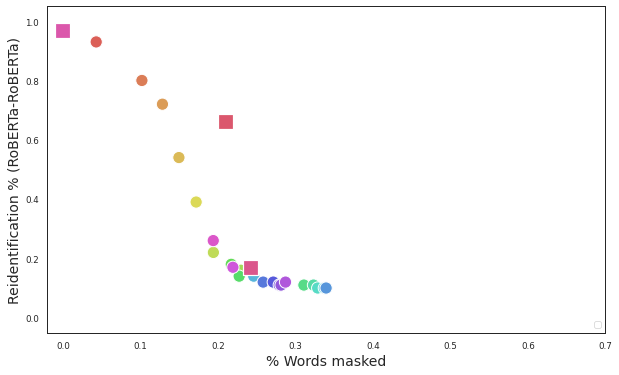

In [17]:
import matplotlib.pyplot as plt

def make_reid_plot(reid_model_name: str, x_column: str, xlabel: str, ylabel: str, marker_size: int = 150, set_lim=True):
    plt.figure(figsize=(10,6))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    group_key = "filename_short"
    
    # df_grouped_filtered = df_grouped
    df_grouped_filtered = df_grouped[
        df_grouped[group_key].apply(lambda row_model_name: (reid_model_name not in row_model_name))
    ]
    # print(df_grouped_filtered)
    y_column = f"{reid_model_name}__was_correct"
    
    g1 = sns.lineplot(
        data=df_grouped_filtered,
        x=x_column,
        y=y_column,
        hue=group_key,
        palette=color_by_model_name,
        linewidth=5,
        legend=False
    )
    # g1.set_xscale('log')
    g1.legend(loc='lower right')
    if set_lim: g1.set(xlim=(0,1), ylim=(-0.05, 1.05))
    for marker_type in df_grouped["marker"].unique():
        df_grouped_marker = df_grouped_filtered[
            df_grouped_filtered["marker"] == marker_type
        ]
        g2 = sns.scatterplot(
            data=df_grouped_marker,
            x=x_column,
            y=y_column,
            hue=group_key,
            palette=color_by_model_name,
            s=(marker_size if marker_type == 'o' else marker_size*1.5),
            marker=marker_type,
            legend=False
        )
        # g2.set_xscale('log')
    if set_lim: g2.set(xlim=(-0.02,0.7), ylim=(-0.05, 1.05))


make_reid_plot(reid_model_name="roberta_roberta", x_column="percent_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="% Words masked", set_lim=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


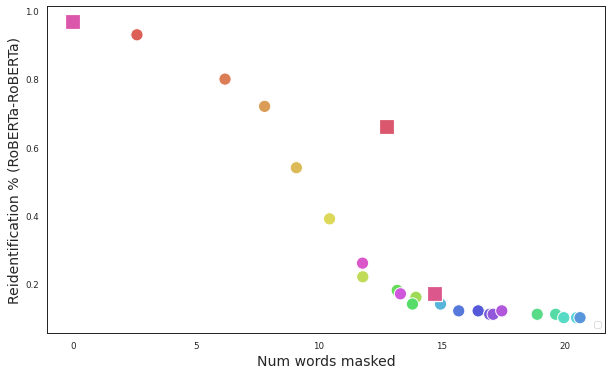

In [9]:
make_reid_plot(reid_model_name="roberta_roberta", x_column="num_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="Num words masked", set_lim=False)

In [10]:
((out_df["model_name"] == "pmlm_tapas") & (out_df["k"] == 1) & (out_df["p"] == 0.2)).count()

2600

In [11]:
df_grouped.iloc[4]

filename                        /home/jxm3/research/deidentification/unsupervi...
index                                                                        49.5
i                                                                            49.5
p                                                                             0.8
original_num_words                                                          60.71
num_words                                                                   60.71
pmlm_tapas__was_correct                                                      0.28
roberta_roberta__was_correct                                                 0.39
roberta_tapas__was_correct                                                   0.38
all_models_were_correct                                                      0.16
num_masks                                                                   10.44
percent_masks                                                            0.171965
percent_not_mask

In [16]:
df_grouped.sort_values(by='roberta_roberta__was_correct')

,filename,index,i,p,original_num_words,num_words,pmlm_tapas__was_correct,roberta_roberta__was_correct,roberta_tapas__was_correct,all_models_were_correct,num_masks,percent_masks,percent_not_masks,filename_short,marker,color
12,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.10,0.08,0.00,19.96,0.328776,0.671224,results__b_1__ts10.0__idf0.0__mp0.98__k_15__n_...,o,"(0.33999999999999997, 0.86, 0.7712000000000001)"
15,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.10,0.08,0.00,20.62,0.339648,0.660352,results__b_1__ts10.0__idf0.0__mp0.98__k_20__n_...,o,"(0.33999999999999997, 0.5887999999999997, 0.86)"
13,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.10,0.08,0.00,20.48,0.337341,0.662659,results__b_1__ts10.0__idf0.0__mp0.98__k_18__n_...,o,"(0.33999999999999997, 0.8287999999999999, 0.86)"
18,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.11,0.17,0.00,16.95,0.279196,0.720804,results__b_1__ts10.0__idf0.0__mp0.98__k_4__n_1...,o,"(0.4511999999999997, 0.33999999999999997, 0.86)"
11,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.11,0.09,0.00,19.63,0.323340,0.676660,results__b_1__ts10.0__idf0.0__mp0.98__k_12__n_...,o,"(0.33999999999999997, 0.86, 0.6512000000000002)"
19,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.11,0.15,0.00,17.09,0.281502,0.718498,results__b_1__ts10.0__idf0.0__mp0.98__k_5__n_1...,o,"(0.5711999999999999, 0.33999999999999997, 0.86)"
10,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.11,0.12,0.00,18.88,0.310987,0.689013,results__b_1__ts10.0__idf0.0__mp0.98__k_10__n_...,o,"(0.33999999999999997, 0.86, 0.5312000000000001)"
7,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.96,60.71,60.71,0.11,0.12,0.14,0.02,16.52,0.272113,0.727887,results__b_1__ts10.0__idf0.0__mp0.96__k_0__n_1...,o,"(0.5087999999999996, 0.86, 0.33999999999999997)"
16,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.12,0.20,0.00,15.69,0.258442,0.741558,results__b_1__ts10.0__idf0.0__mp0.98__k_2__n_1...,o,"(0.33999999999999997, 0.4687999999999997, 0.86)"
17,/home/jxm3/research/deidentification/unsupervi...,49.5,49.5,0.98,60.71,60.71,0.00,0.12,0.20,0.00,16.48,0.271454,0.728546,results__b_1__ts10.0__idf0.0__mp0.98__k_3__n_1...,o,"(0.33999999999999997, 0.3487999999999998, 0.86)"
